In [336]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
import yaml
import xarray as xr
import numpy as np
import xgcm
import matplotlib.pyplot as plt

In [338]:
import xwmt

### Generalized tracer budget metadata dictionary, with common examples formatted as yaml files

In [340]:
with open("../conventions/MOM6.yaml", "r") as stream:
    try:
        a = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
a

{'heat': {'lambda': 'thetao',
  'lhs': {'tendency': 'opotemptend'},
  'rhs': {'horizontal_advection"': 'T_advection_xy',
   'vertical_advection': 'Th_tendency_vert_remap',
   'boundary_forcing': 'boundary_forcing_heat_tendency',
   'vertical_diffusion': 'opottempdiff',
   'neutral_diffusion': 'opottemppmdiff',
   'frazil_ice': 'frazil_heat_tendency',
   'geothermal': 'internal_heat_heat_tendency'}},
 'salt': {'lambda': 'salt',
  'lhs': {'tendency': 'osalttend'},
  'rhs': {'horizontal_advection': 'S_advection_xy',
   'vertical_advection': 'Sh_tendency_vert_remap',
   'boundary_forcing': 'boundary_forcing_salt_tendency',
   'vertical_diffusion': 'osaltdiff',
   'neutral_diffusion': 'osaltpmdiff',
   'frazil_ice': None,
   'geothermal': None}}}

### Simple test example (can be compared against analytical solution)

In [352]:
ds = xr.Dataset()

dz = 1.e-2
ds = ds.assign_coords({
    'z_i': xr.DataArray(np.arange(0., 1.+dz, dz), dims=("z_i",)),
    'z_l': xr.DataArray(np.arange(dz/2., 1., dz), dims=("z_l",)),
})
ds = ds.assign_coords({'dz': dz*xr.ones_like(ds.z_l)})

budget_dict = {'heat': {
    'lambda': 'theta',
    'lhs': {'tendency':'total_heating_rate'},
    'rhs': {
        'vertical_diffusion':'vertical_diffusion',
        'external_heating':'external_heating'
    }
}}
def idealized_diffusion(z):
    return np.sin(2*np.pi*z)
ds['vertical_diffusion'] = xr.DataArray(idealized_diffusion(ds.z_l), coords=(ds.z_l,))*ds.dz
ds['external_heating'] = xr.ones_like(ds.vertical_diffusion)*ds.dz
ds['total_heating_rate'] = ds['vertical_diffusion'] + ds['external_heating']

ds['theta'] = xr.DataArray(ds.z_l.data, coords=(ds.z_l,))

# expand to horizontal dimension and add grid metrics
ds = ds.expand_dims(dim=('x', 'y')).assign_coords({'x':xr.DataArray([1.], dims=('x',)), 'y':xr.DataArray([1.], dims=('y',))})
ds = ds.assign_coords({'rA': xr.DataArray([[1.]], dims=('x','y',))})

metrics = {
    ('X',): [], # X distances
    ('Y',): [], # Y distances
    ('Z',): ['dz'], # Z distances
    ('X', 'Y'): ['rA'] # Areas
}
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
    'Z': {'center': 'z_l', 'outer': 'z_i'},
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, periodic=['X', 'Y'])

In [353]:
wmt = xwmt.WaterMassTransformations(ds, grid, budgets_dict=budget_dict)

In [364]:
T = wmt.integrate_transformation_rates('heat', ds['z_i'].values)

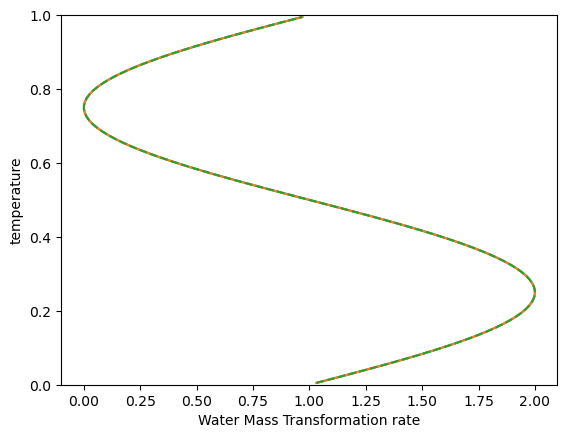

In [366]:
T['heat']['lhs']['tendency'].plot(y='theta', label="RHS")
(T['heat']['rhs']['external_heating'] + T['heat']['rhs']['vertical_diffusion']).plot(y='theta', label="LHS")
plt.plot(idealized_diffusion(ds.z_l)+1., ds.theta.mean(['x', 'y']), ls="--", label="Analytical solution")
plt.xlabel("Water Mass Transformation rate")
plt.ylabel("temperature")
plt.ylim(0,1);